# Compare grass growth time series using MERA for each county at a weekly frequency

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import seaborn as sns
import xarray as xr
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from shapely.geometry import Polygon
import climag.plot_configs as cplt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
df1 = pd.read_csv(os.path.join(
        "data", "grass_growth", "pasturebase", "pasturebase_cleaned.csv"
))
df2 = pd.read_csv(os.path.join(
    "data", "grass_growth", "grasscheck", "grasscheck_cleaned.csv"
))
df = pd.concat([df1, df2])
df_p = pd.pivot_table(
    df[["time", "county", "value"]],
    values="value", index=["time"], columns=["county"]
)
df_p.index = pd.to_datetime(df_p.index)

In [3]:
mera = pd.read_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week.csv")
)
mera.rename(columns={"COUNTY": "county", "mean": "value"}, inplace=True)
mera["county"] = mera["county"].str.title()
mera_p = pd.pivot_table(
    mera, values="value", index=["time"], columns=["county"]
)
mera_p.index = pd.to_datetime(mera_p.index)

In [4]:
counties = list(df_p)

In [5]:
df["data"] = "Measured"
mera["data"] = "Simulated"
data_all = pd.concat([df, mera])
data_all.set_index("time", inplace=True)
data_all.index = pd.to_datetime(data_all.index)
# data_all_p = pd.pivot_table(
#     data_all[["county", "value", "data"]],
#     values="value", index=["time"], columns=["county", "data"]
# )
# data_all_p.resample("Y").mean()

## Weekly time series plots

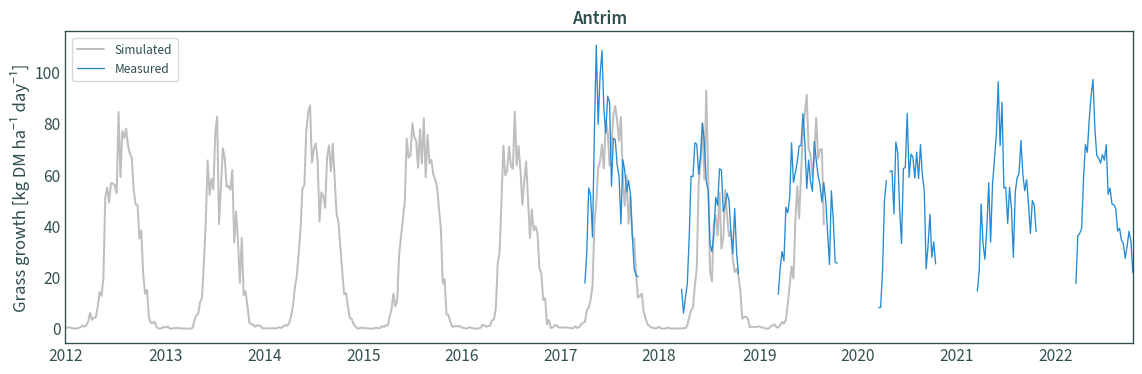

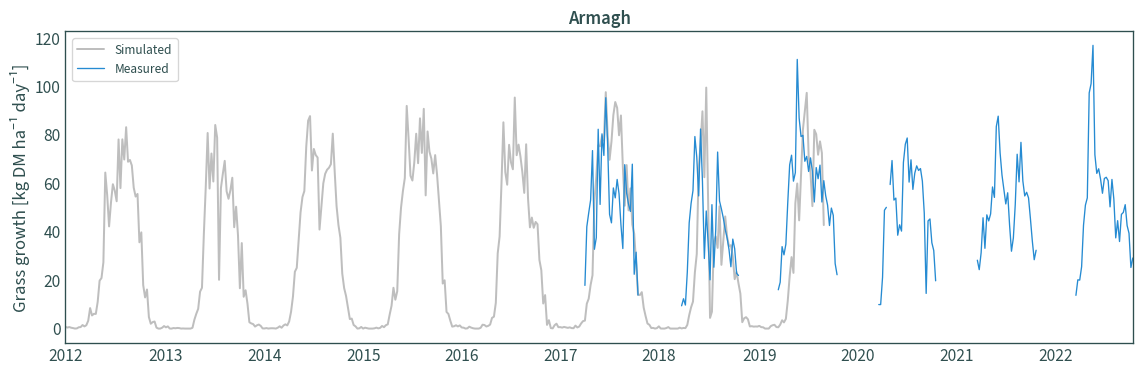

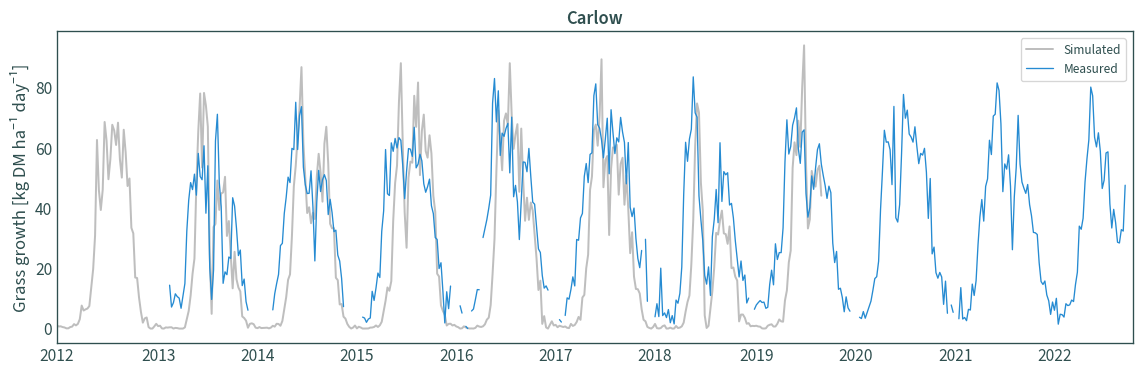

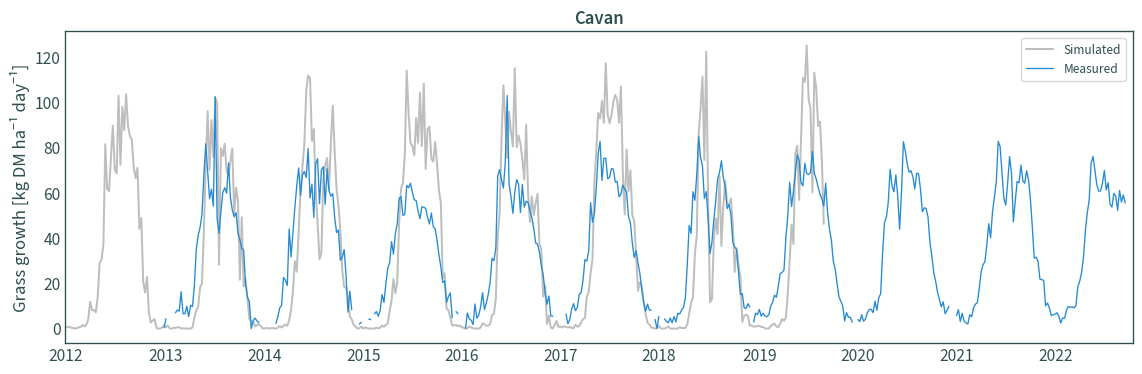

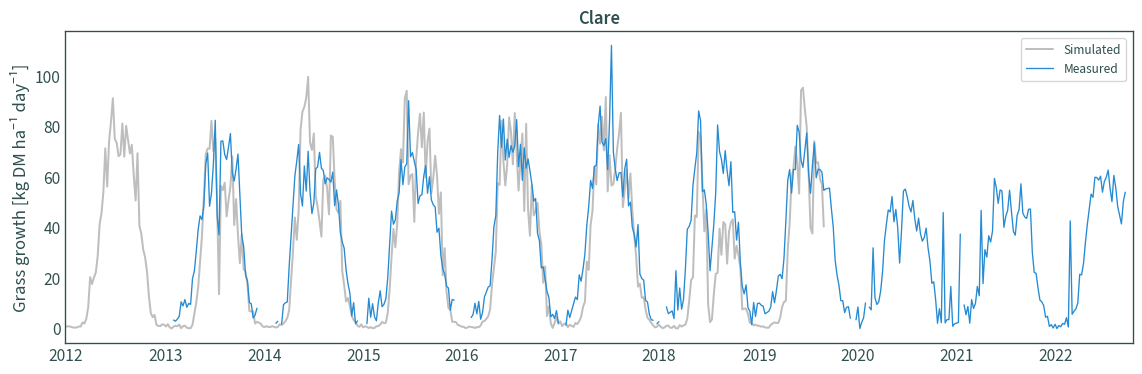

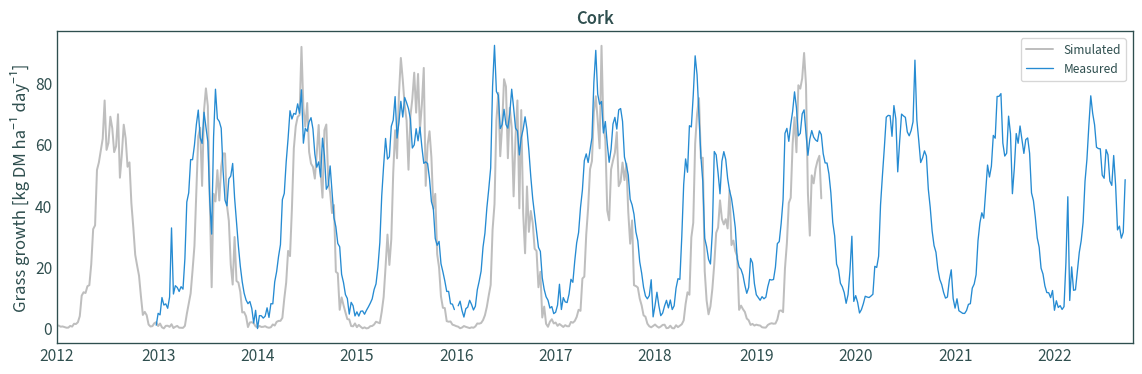

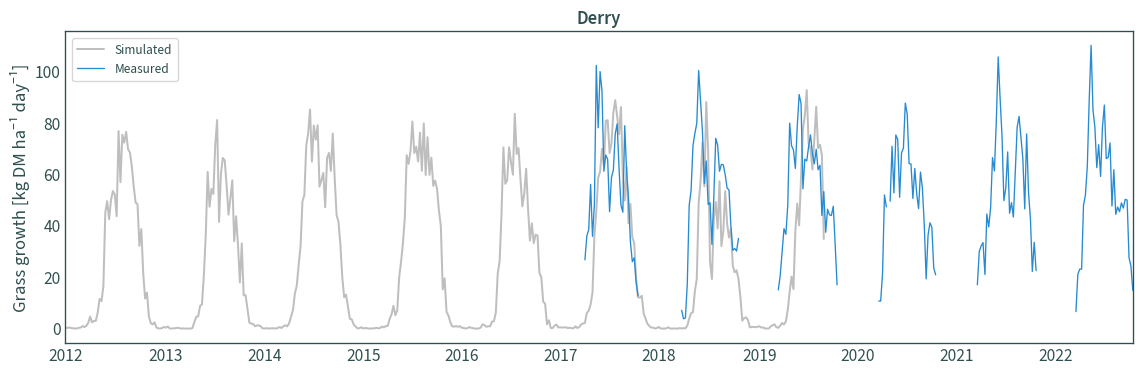

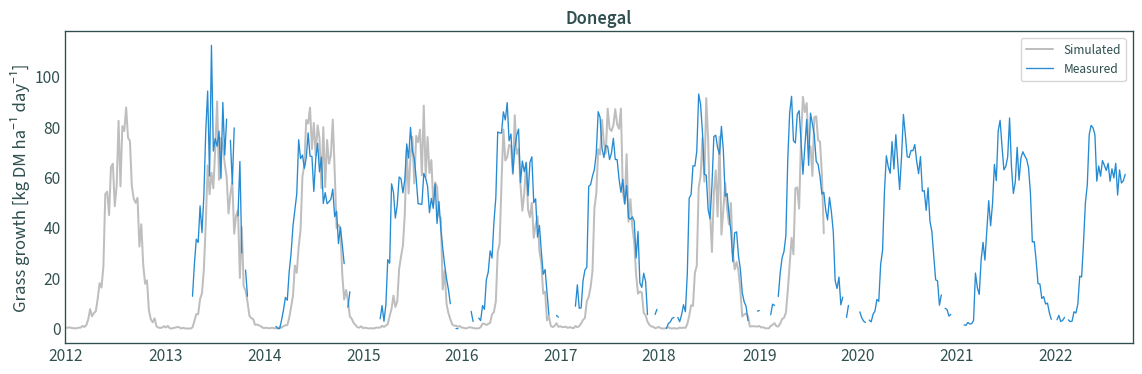

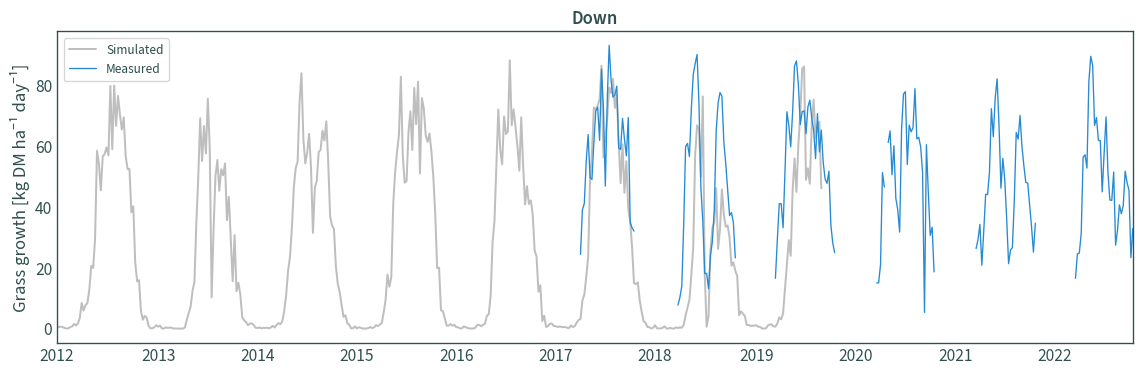

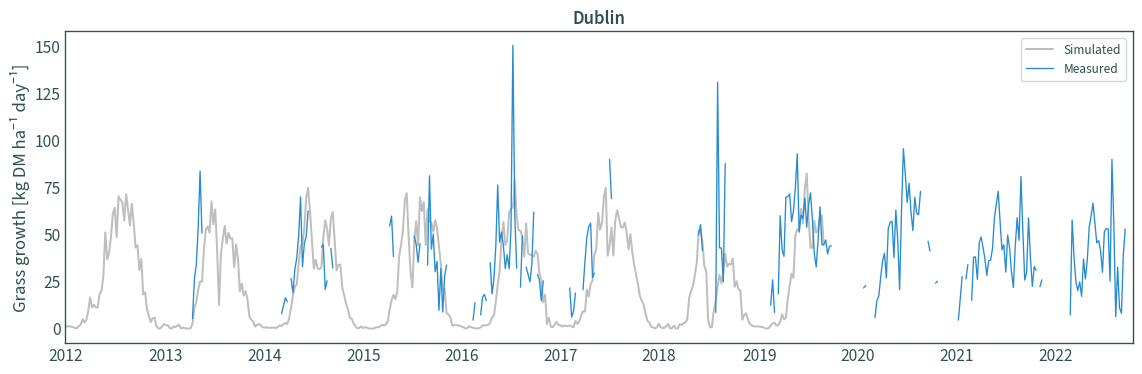

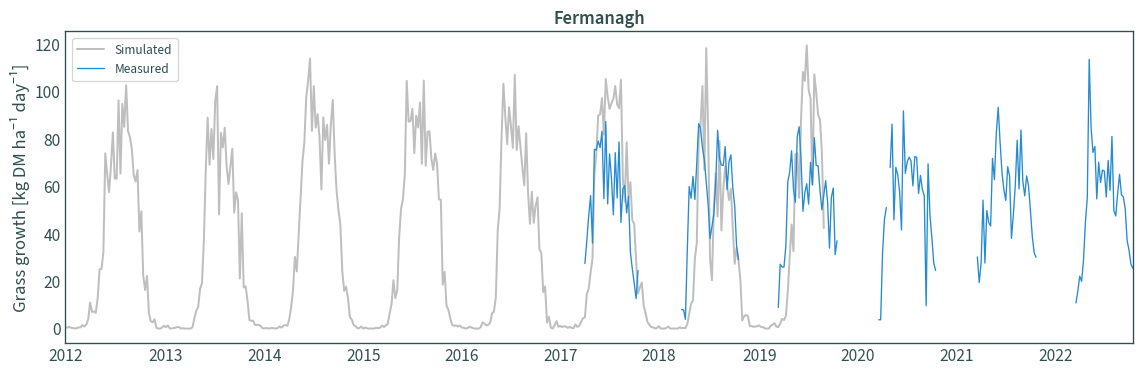

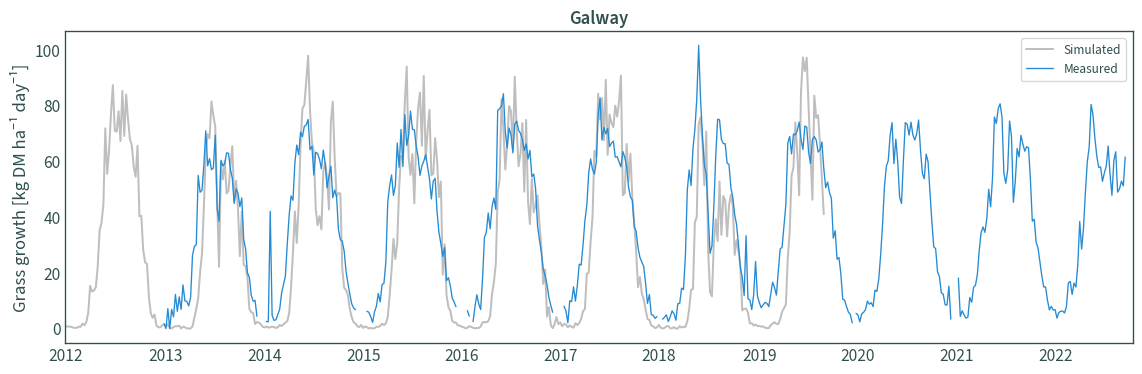

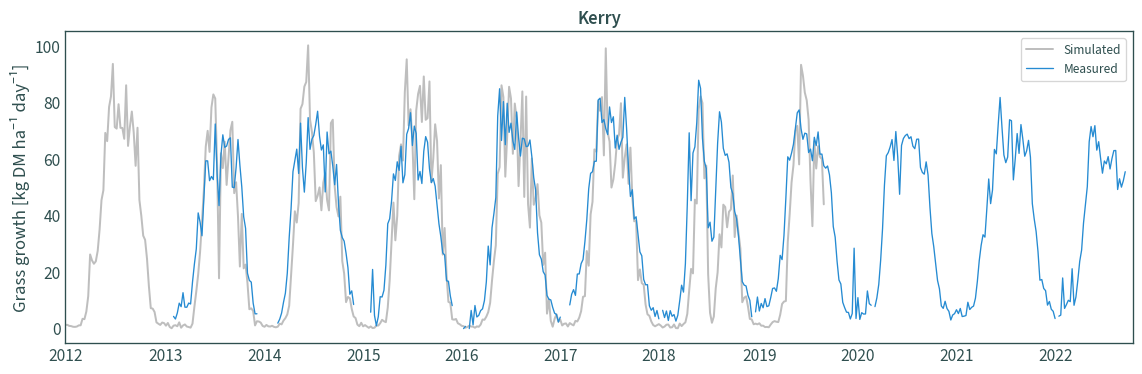

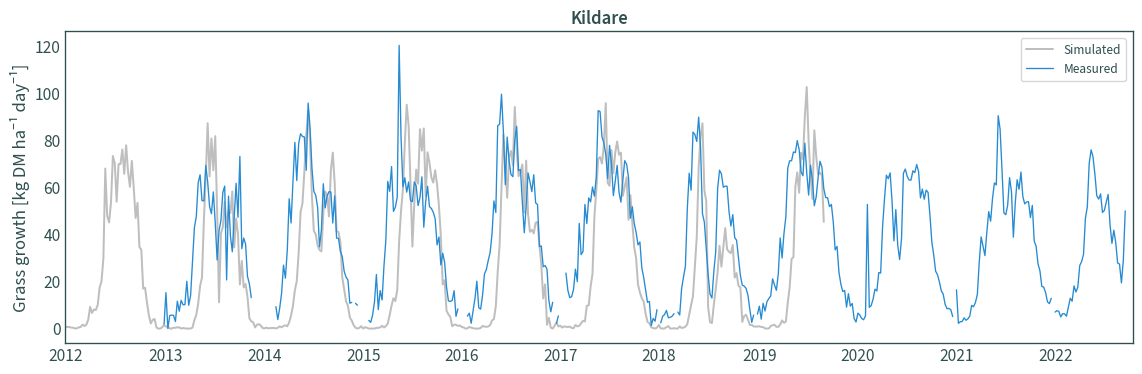

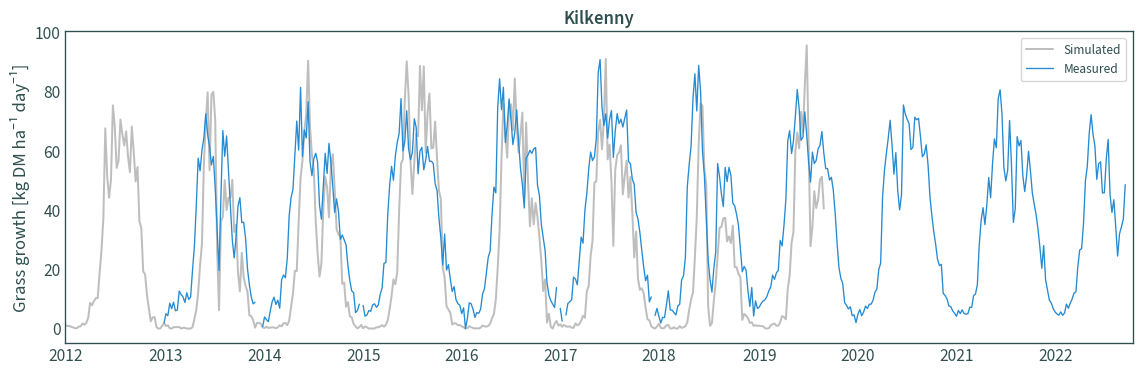

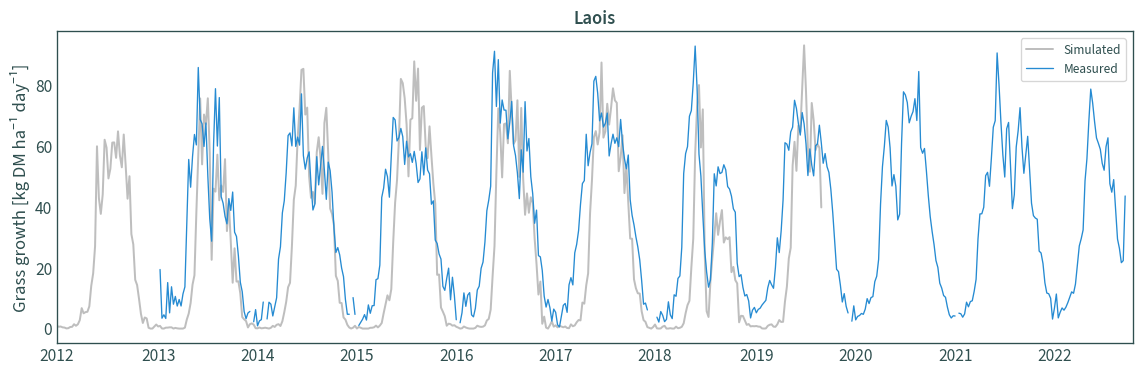

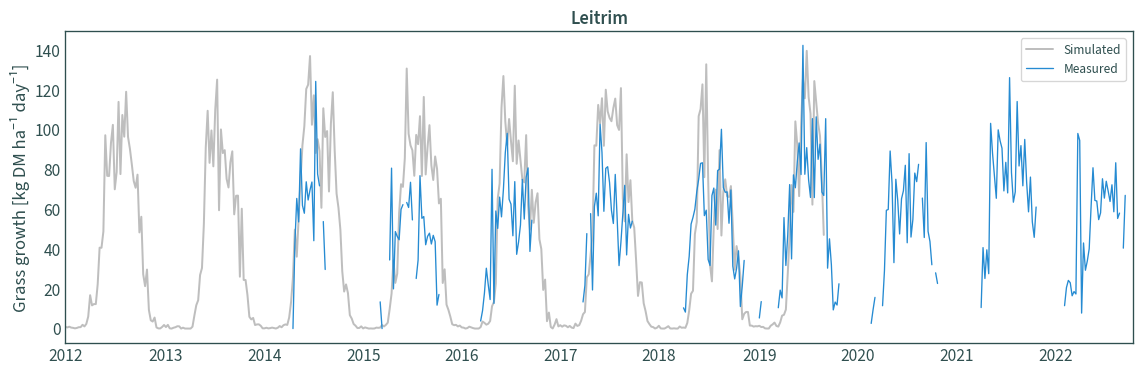

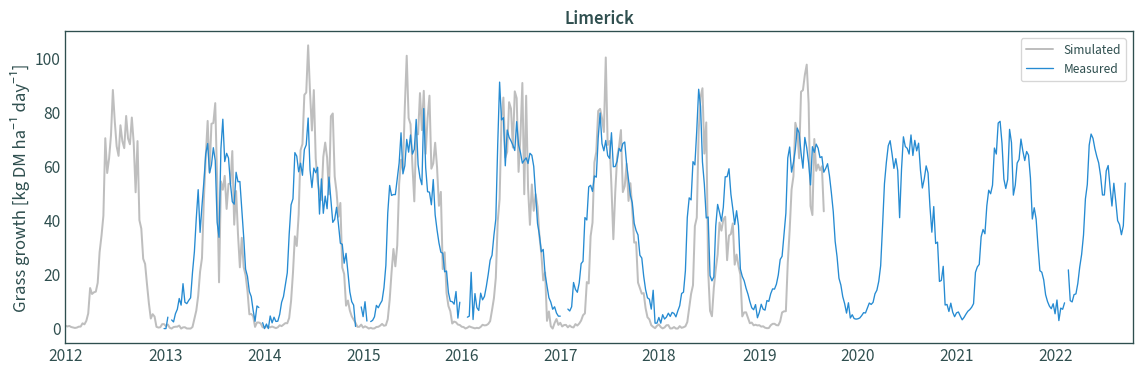

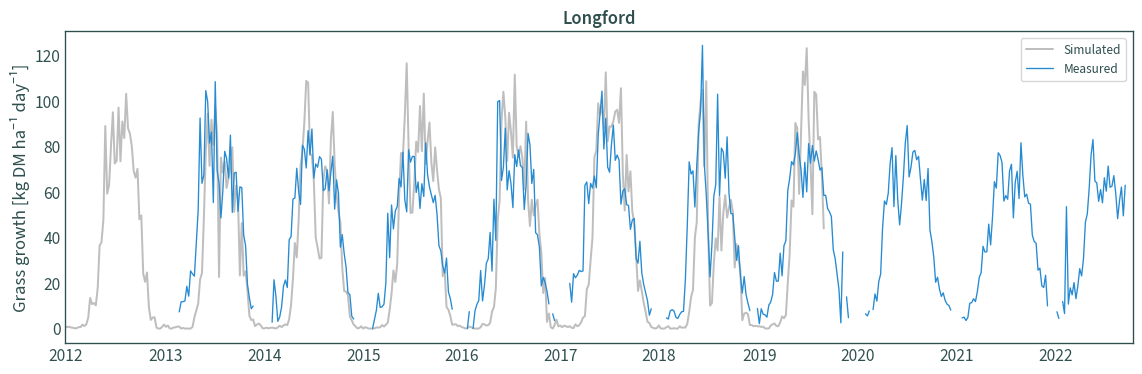

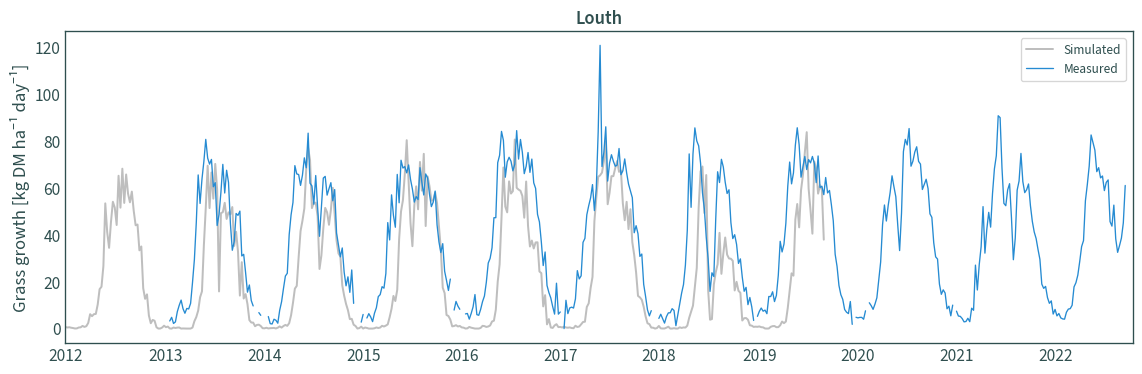

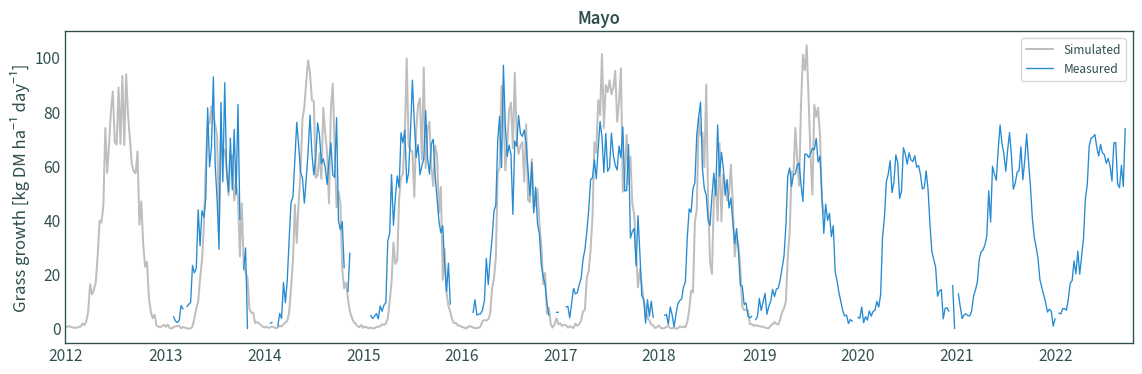

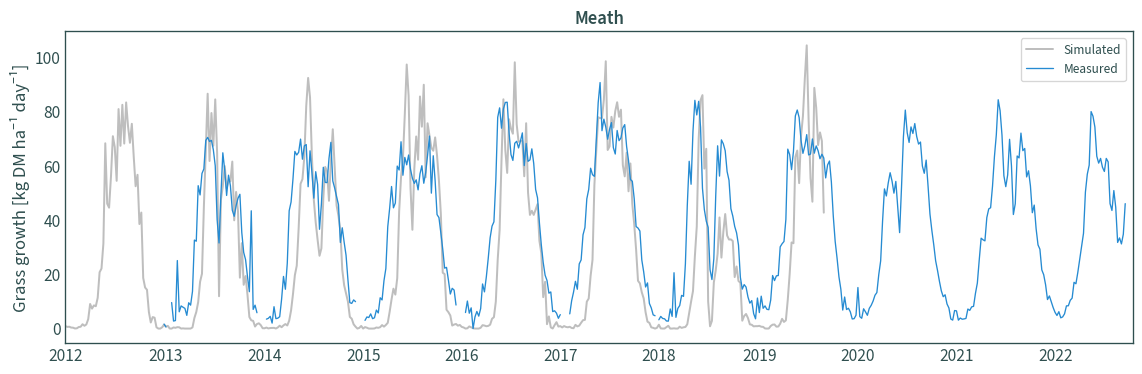

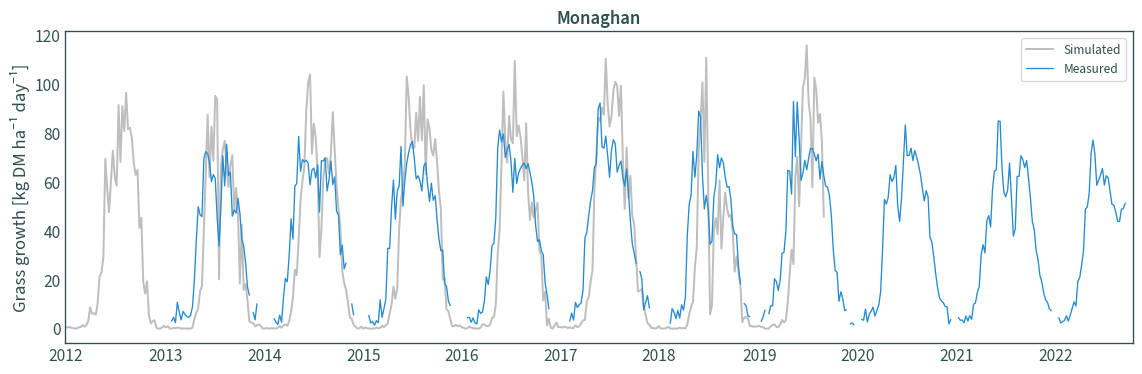

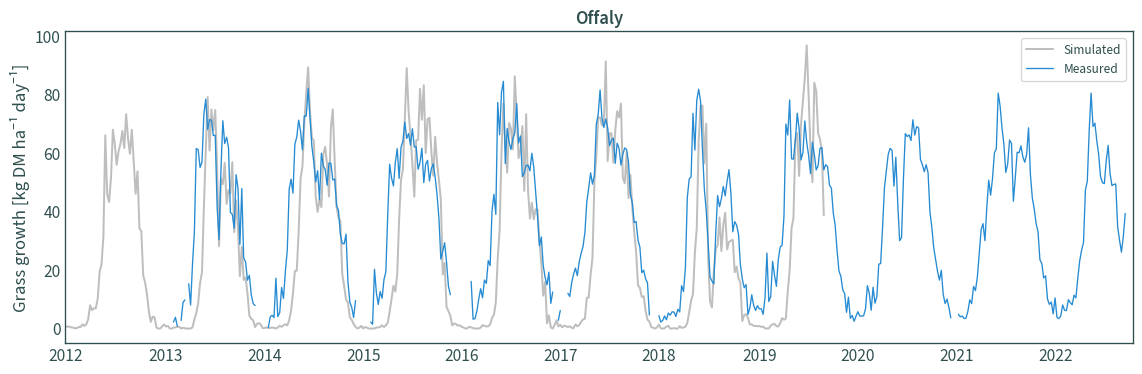

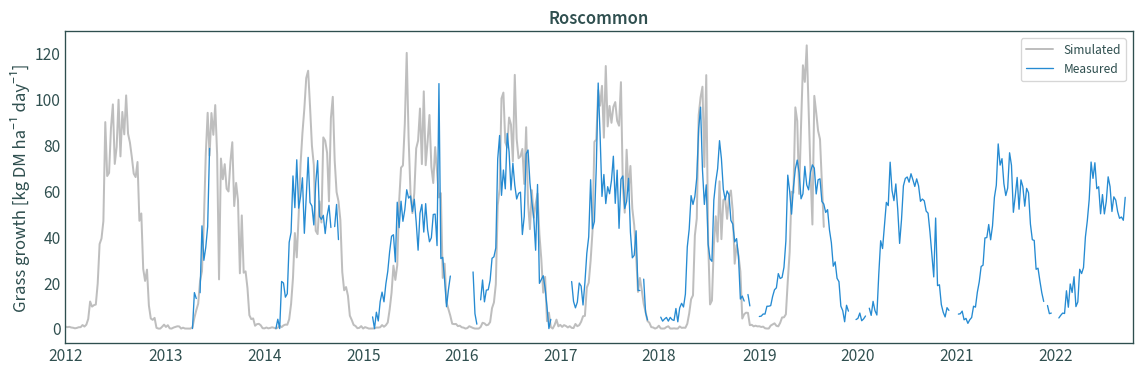

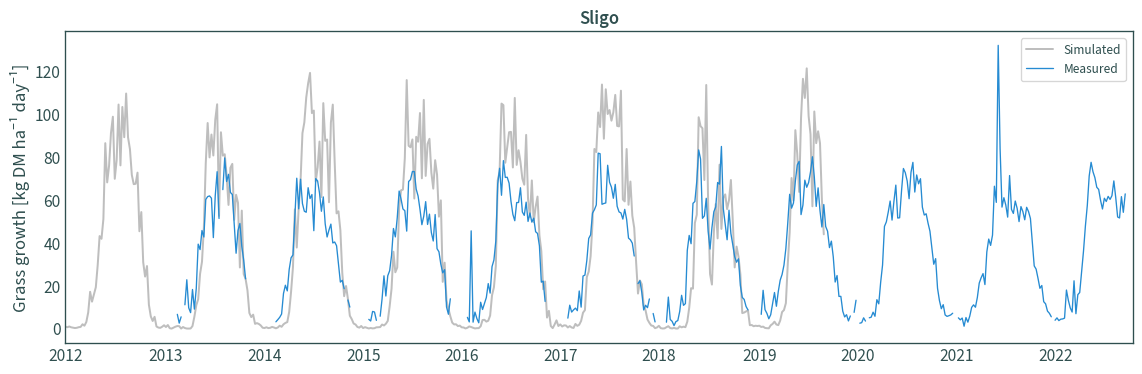

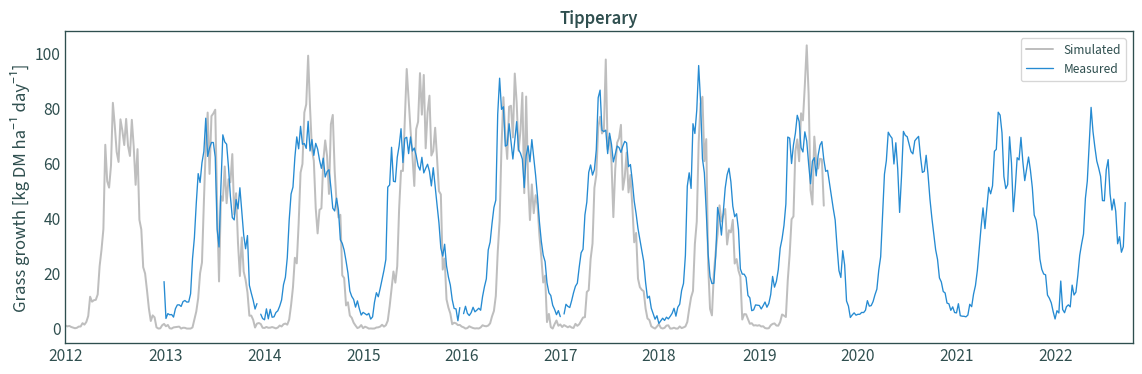

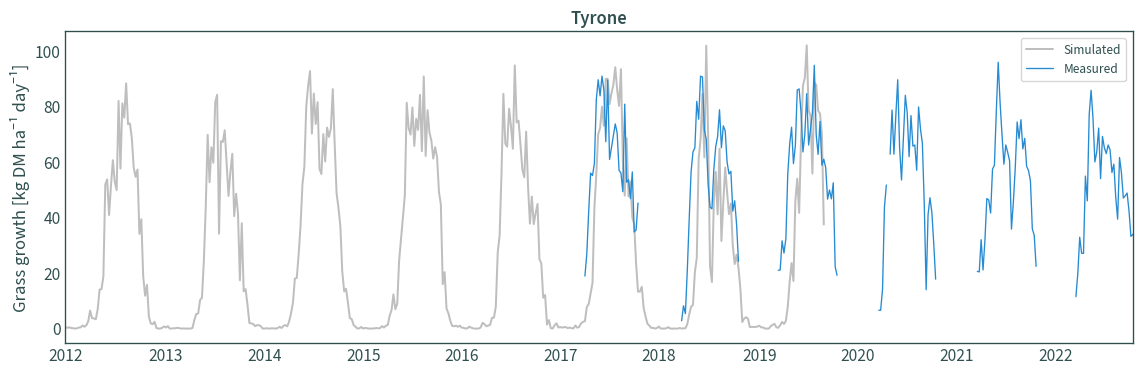

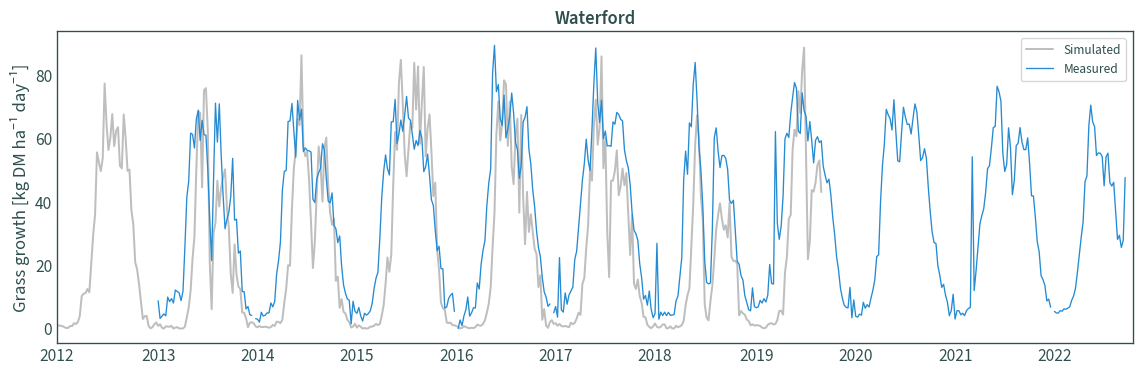

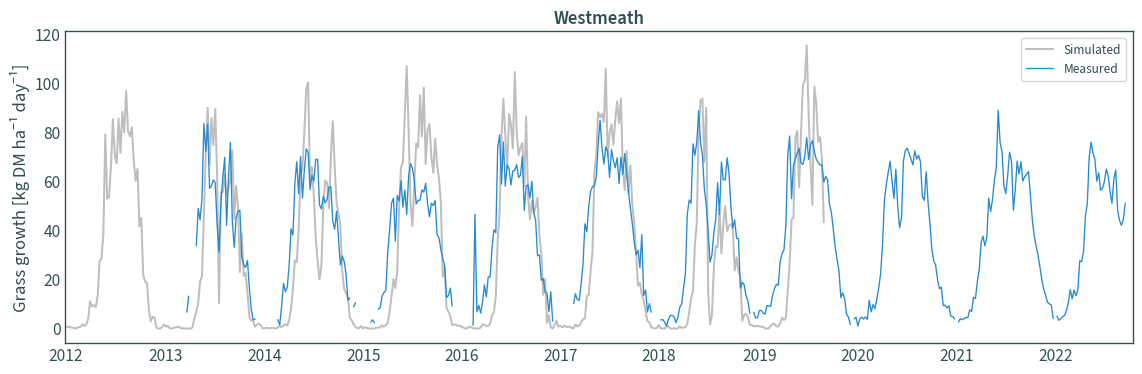

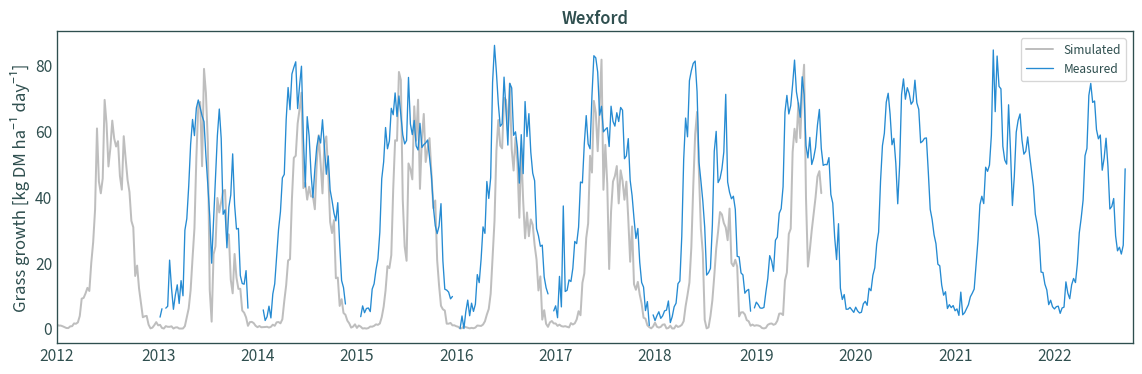

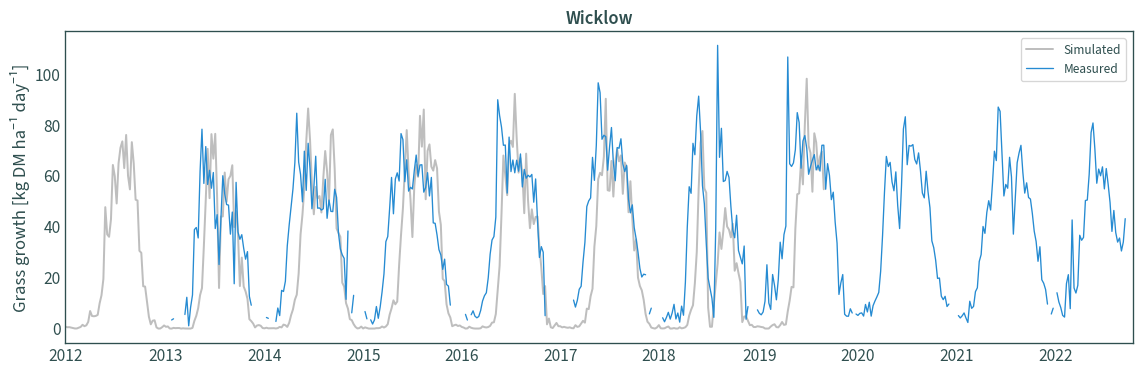

In [6]:
for county in counties:
    fig = mera_p["2012":"2019"][county].plot(
        figsize=(12, 4), label="Simulated", color="darkgrey", alpha=.75
    )
    df_p[county].plot(
        ax=fig.axes, label="Measured", linewidth=1
    )
    plt.legend(title=None)
    plt.xlabel("")
    plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
    plt.title(county)
    plt.tight_layout()
    plt.show()

## Stats

In [103]:
def get_plot_data(data_m, data_s, county, season=None):
    plot_data = pd.merge(
        data_m[[county]].rename(columns={county: "Measured"}),
        data_s[[county]].rename(columns={county: "Simulated"}),
        left_index=True, right_index=True
    ).dropna()
    if season == "MAM":
        plot_data = plot_data[
            (plot_data.index.month == 3) | (plot_data.index.month == 4) |
            (plot_data.index.month == 5)
        ]
    elif season == "JJA":
        plot_data = plot_data[
            (plot_data.index.month == 6) | (plot_data.index.month == 7) |
            (plot_data.index.month == 8)
        ]
    elif season == "MarOct":
        plot_data = plot_data[
            (plot_data.index.month != 1) & (plot_data.index.month != 2) &
            (plot_data.index.month != 11) & (plot_data.index.month != 12)
        ]

    return plot_data

In [114]:
def rmse_by_county(data_m, data_s, counties=counties, season=None):
    rmse = pd.DataFrame(columns=["County", "RMSE"])
    for i, county in enumerate(counties):
        plot_data = get_plot_data(data_m, data_s, county, season)
        rmse.loc[i] = [
            county,
            mean_squared_error(
                plot_data["Measured"], plot_data["Simulated"], squared=False
            )
        ]
    rmse.sort_values(by=["RMSE"], inplace=True)
    return rmse

In [115]:
def get_linear_regression(data_m, data_s, counties=counties, season=None):

    for county in counties:
        plot_data = get_plot_data(data_m, data_s, county, season)

        x = plot_data["Measured"]
        y = plot_data["Simulated"]

        model = sm.OLS(y, sm.add_constant(x))
        results = model.fit()
        print(county)
        print(results.summary())

        fig = plot_data.plot.scatter(x="Measured", y="Simulated", marker="x")
        b, m = results.params
        plt.axline(
            xy1=(0, b), slope=m, label=f"$y = {m:.2f}x {b:+.2f}$",
            color="crimson", linestyle="dotted"
        )
        plt.legend()
        plt.tight_layout()
        plt.show()

### MAM

#### RMSE

In [117]:
rmse_by_county(df_p, mera_p, season="MAM")

,County,RMSE
4,Clare,16.408209
25,Sligo,16.441312
12,Kerry,17.662093
20,Mayo,18.831003
3,Cavan,20.292436
24,Roscommon,20.937893
17,Limerick,22.018592
11,Galway,24.586553
29,Westmeath,25.099903
16,Leitrim,25.863386


#### Linear regression

Clare
                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     357.3
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           9.83e-33
Time:                        11:46:48   Log-Likelihood:                -346.72
No. Observations:                  90   AIC:                             697.4
Df Residuals:                      88   BIC:                             702.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1185      2.214     -5.021   

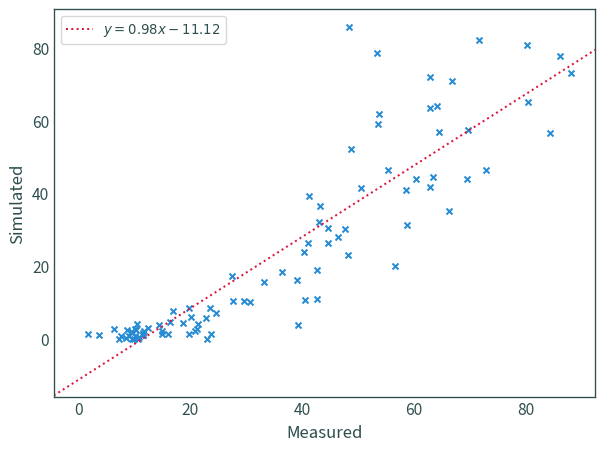

In [120]:
get_linear_regression(df_p, mera_p, counties=["Clare"], season="MAM")

### JJA

#### RMSE

In [118]:
rmse_by_county(df_p, mera_p, season="JJA")

,County,RMSE
23,Offaly,13.100566
26,Tipperary,14.352763
2,Carlow,14.359889
5,Cork,14.418465
15,Laois,15.119784
14,Kilkenny,15.252214
19,Louth,16.198558
11,Galway,16.274997
28,Waterford,16.332412
17,Limerick,16.638418


#### Linear regression

Clare
                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     12.40
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           0.000676
Time:                        11:47:06   Log-Likelihood:                -404.21
No. Observations:                  92   AIC:                             812.4
Df Residuals:                      90   BIC:                             817.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.5016     10.711      2.287   

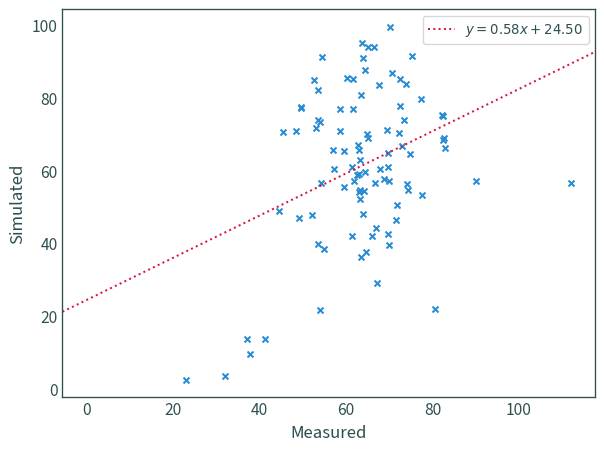

In [121]:
get_linear_regression(df_p, mera_p, counties=["Clare"], season="JJA")

### March to October

#### RMSE

In [119]:
rmse_by_county(df_p, mera_p, season="MarOct")

,County,RMSE
12,Kerry,17.609832
4,Clare,17.813205
20,Mayo,18.690636
17,Limerick,18.756285
11,Galway,19.304858
2,Carlow,20.803311
5,Cork,20.838603
23,Offaly,21.219979
26,Tipperary,21.396385
7,Donegal,21.733782


#### Linear regression

Clare
                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     403.6
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           7.54e-53
Time:                        11:47:23   Log-Likelihood:                -998.60
No. Observations:                 236   AIC:                             2001.
Df Residuals:                     234   BIC:                             2008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6223      2.690     -2.462   

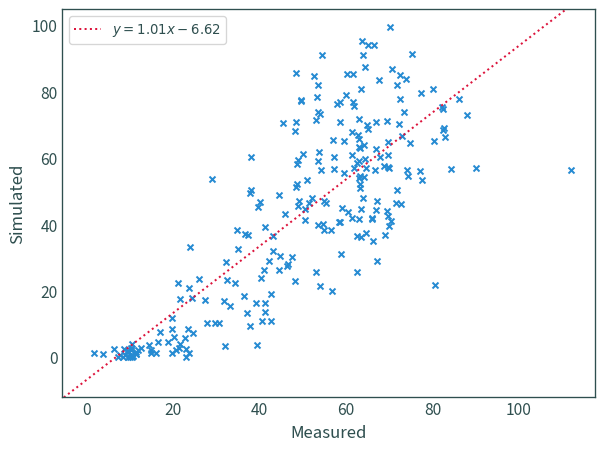

In [122]:
get_linear_regression(df_p, mera_p, counties=["Clare"], season="MarOct")

### All

#### RMSE

In [108]:
rmse_by_county(df_p, mera_p)

,County,RMSE
4,Clare,15.526567
12,Kerry,15.528098
17,Limerick,16.198397
20,Mayo,16.749141
11,Galway,17.006034
5,Cork,17.938669
26,Tipperary,18.277273
2,Carlow,18.702583
28,Waterford,18.906325
23,Offaly,19.037480


## Box plots - MAM growth grouped by year

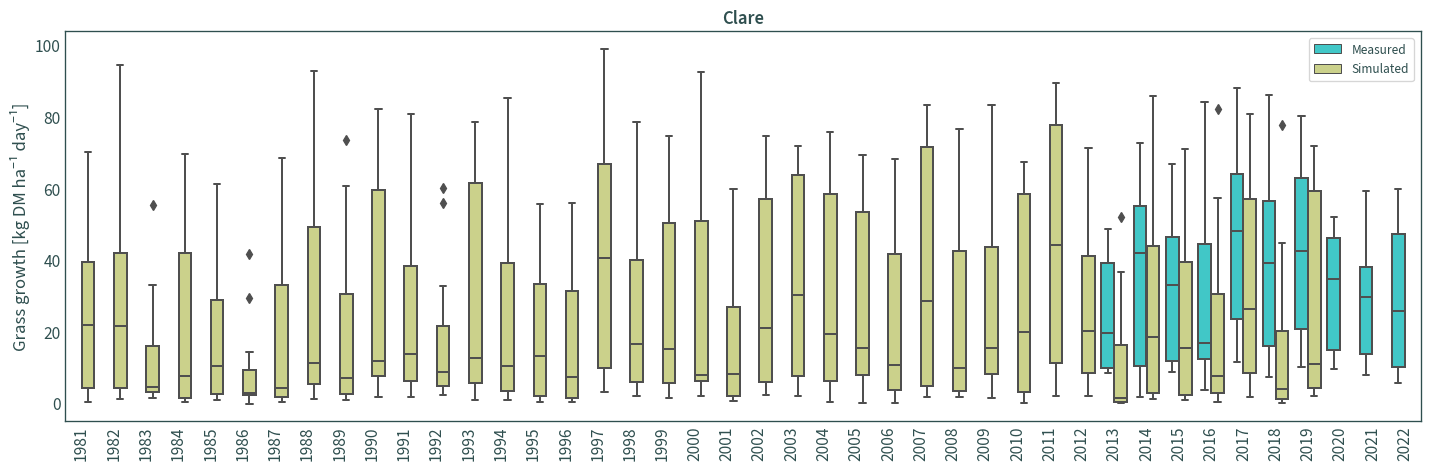

In [55]:
for county in ["Clare"]:
    plot_data = data_all[(data_all["county"] == county)]
    # remove Jan, Feb, Nov, Dec data
    plot_data = plot_data[
        (plot_data.index.month == 3) | (plot_data.index.month == 4) |
        (plot_data.index.month == 5)
    ]
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(
        x=plot_data.index.year, y=plot_data["value"], hue=plot_data["data"],
        ax=ax, palette="rainbow"
    )
    plt.xlabel("")
    ax.tick_params(axis="x", rotation=90)
    plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
    plt.title(county)
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

## Box plots - JJA growth grouped by year

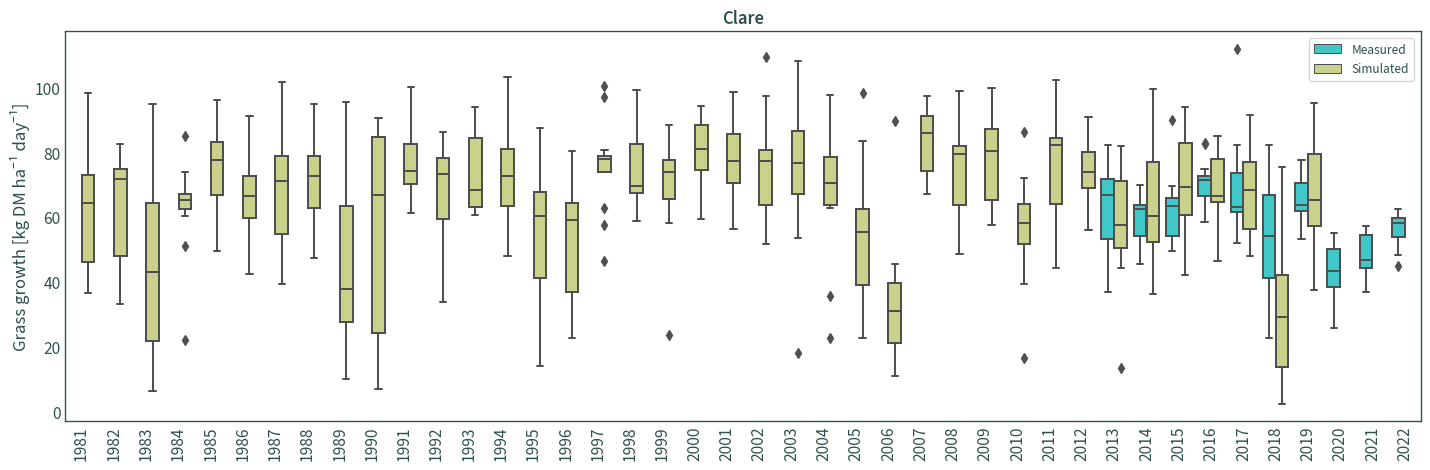

In [56]:
for county in ["Clare"]:
    plot_data = data_all[(data_all["county"] == county)]
    # remove Jan, Feb, Nov, Dec data
    plot_data = plot_data[
        (plot_data.index.month == 6) | (plot_data.index.month == 7) |
        (plot_data.index.month == 8)
    ]
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(
        x=plot_data.index.year, y=plot_data["value"], hue=plot_data["data"],
        ax=ax, palette="rainbow"
    )
    plt.xlabel("")
    ax.tick_params(axis="x", rotation=90)
    plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
    plt.title(county)
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

## Box plots - March - October growth grouped by year

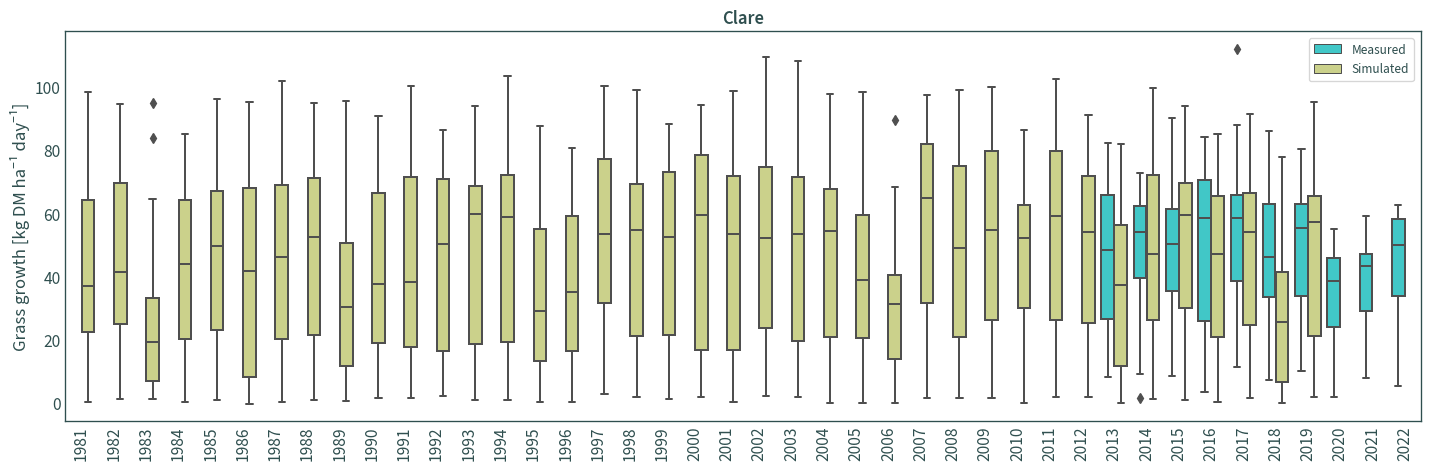

In [57]:
for county in ["Clare"]:
    plot_data = data_all[(data_all["county"] == county)]
    # remove Jan, Feb, Nov, Dec data
    plot_data = plot_data[
        (plot_data.index.month != 1) & (plot_data.index.month != 2) &
        (plot_data.index.month != 11) & (plot_data.index.month != 12)
    ]
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(
        x=plot_data.index.year, y=plot_data["value"], hue=plot_data["data"],
        ax=ax, palette="rainbow"
    )
    plt.xlabel("")
    ax.tick_params(axis="x", rotation=90)
    plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
    plt.title(county)
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()